# Calculate median price

In [ ]:
from google.colab import drive
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sortedcontainers import SortedList
import numpy as np

In [ ]:
drive.mount('/content/drive')

In [ ]:
nft_transactions_ = pd.read_csv('data/Data_API.csv',usecols=['Datetime_updated','Datetime_updated_seconds','Unique_id_collection','Collection_cleaned','Price_USD'])

In [ ]:
nft_transactions = nft_transactions_.copy(deep=True)
nft_transactions.Datetime_updated_seconds = pd.to_datetime(nft_transactions.Datetime_updated_seconds)
nft_transactions.Datetime_updates = pd.to_datetime(nft_transactions.Datetime_updated)
nft_transactions.sort_values('Datetime_updated_seconds',inplace=True)

Convert dataframe to dictionary for fast iteration

In [ ]:
nfts = nft_transactions.to_dict('index')

Magic

In [ ]:
def median(sorted_list):
  length = len(sorted_list)
  mid_index = length // 2
  if length % 2 == 0:
    #print(sorted_list)
    mid_1 = sorted_list[mid_index][0]
    mid_2 = sorted_list[mid_index - 1][0]
    return (mid_1 + mid_2) / 2
  else:
    return sorted_list[mid_index][0]

collection_sales = {}
nft_values = {}
time_interval = pd.to_timedelta(7, unit='d')
for index, nft in tqdm(nfts.items()):
  price_usd = nft['Price_USD']
  collection_cleaned = nft['Collection_cleaned']
  datetime_updated_seconds = nft['Datetime_updated_seconds']
  if collection_cleaned not in collection_sales:
    collection_sales[collection_cleaned] = np.array([(0,0)]).reshape(1,2)
  if collection_sales[collection_cleaned].shape[0] > 1:
    median_price = np.median(collection_sales[collection_cleaned][:,0])
  else:
    median_price = 0
  nft_values[index] = {
    'median_price':median_price
  }
  collection_sales[collection_cleaned] = np.concatenate((collection_sales[collection_cleaned], [(price_usd, datetime_updated_seconds)]))
  #a = np.array(collection_sales[collection_cleaned])
  # index_list = np.where(a[:,1] < datetime_updated_seconds - time_interval)[0]
  # if index_list:
  #   index = index_list[-1]
  #   collection_sales[collection_cleaned] = a[index+1:]
  # for i in range(len(collection_sales[collection_cleaned]))[::-1]:
  #   pass
    # if collection_sales[collection_cleaned][i][1] < datetime_updated_seconds - time_interval:
    #   del collection_sales[collection_cleaned][i]
df_medianprice = pd.DataFrame.from_dict(nft_values, orient='index')
df_medianprice

Transfer the columns from the calculation to the original dataframe

In [ ]:
nft_transactions['median_price'] = df_medianprice['median_price']
nft_transactions

,Price_USD,Datetime_updated,Datetime_updated_seconds,Unique_id_collection,Collection_cleaned,median_price
242722,3.970675,2017-11-23 00:00:00,2017-11-23 18:44:21,"('Cryptokitties', '1001')",Cryptokittie,0.000000
242721,3.902311,2017-11-23 00:00:00,2017-11-23 18:44:21,"('Cryptokitties', '1002')",Cryptokittie,3.970675
242720,3.928712,2017-11-23 00:00:00,2017-11-23 18:44:21,"('Cryptokitties', '1003')",Cryptokittie,3.936493
242719,3.902311,2017-11-23 00:00:00,2017-11-23 18:44:21,"('Cryptokitties', '1004')",Cryptokittie,3.928712
242718,3.828667,2017-11-23 00:00:00,2017-11-23 18:44:21,"('Cryptokitties', '1005')",Cryptokittie,3.915511
...,...,...,...,...,...,...
2338572,0.082960,2021-04-27 00:00:00,2021-04-27 23:59:55,"('alien.worlds', '1099529894344')",Alien,0.109504
2338573,0.072590,2021-04-27 00:00:00,2021-04-27 23:59:55,"('alien.worlds', '1099529899954')",Alien,0.109504
2338570,0.076738,2021-04-27 00:00:00,2021-04-27 23:59:55,"('alien.worlds', '1099529899571')",Alien,0.109504
2338569,0.076738,2021-04-27 00:00:00,2021-04-27 23:59:56,"('alien.worlds', '1099529899986')",Alien,0.109504


Check if the algorithm we used produces expected result on a collection

In [ ]:
nft_transactions[nft_transactions.Collection_cleaned == 'Cryptocelebritie'].loc[:,['Datetime_updated_seconds','median_price','Price_USD']]

,Datetime_updated_seconds,median_price,Price_USD
4169376,2018-02-04 06:33:49,0.000000,1533.358750
4169375,2018-02-05 04:10:37,1533.358750,14917.917977
4169374,2018-02-05 18:11:58,8225.638364,3714.381350
4169373,2018-02-05 18:18:39,3714.381350,1486.900000
4169372,2018-02-05 18:44:12,2623.870050,1115.175000
...,...,...,...
4504589,2019-07-27 05:13:11,1628.471000,104.120000
4504588,2019-07-27 05:13:11,1628.471000,20.824000
4504587,2019-07-27 05:13:12,1628.471000,20.824000
4504585,2019-07-27 05:18:57,1623.486700,266.547200


These values are calculated on seconds precision. This leads to values being calculated with NFT transactions made seconds ago.  
We want to use daily resolution, which will lead to calculations being up to only the previous day of the NFT transaction.


In [ ]:
day_precision = nft_transactions.groupby(['Datetime_updated','Collection_cleaned']).first().reset_index()
day_precision

,Datetime_updated,Collection_cleaned,Price_USD,Datetime_updated_seconds,Unique_id_collection,median_price
0,2017-11-23 00:00:00,Cryptokittie,3.970675,2017-11-23 18:44:21,"('Cryptokitties', '1001')",0.000000
1,2017-11-24 00:00:00,Cryptokittie,43.144134,2017-11-24 00:01:51,"('Cryptokitties', '1131')",3.900504
2,2017-11-25 00:00:00,Cryptokittie,3.258280,2017-11-25 00:09:16,"('Cryptokitties', '5794')",4.035148
3,2017-11-26 00:00:00,Cryptokittie,1.427850,2017-11-26 00:00:39,"('Cryptokitties', '3882')",3.983181
4,2017-11-27 00:00:00,Cryptokittie,1.147136,2017-11-27 00:25:17,"('Cryptokitties', '8704')",3.976233
...,...,...,...,...,...,...
83012,2021-04-27 00:00:00,Xcopy,1288.434039,2021-04-27 03:05:42,"('Xcopy', '17600020825')",1765.320000
83013,2021-04-27 00:00:00,Xmonsxyz,3157.926567,2021-04-27 12:57:23,"('0xmons-xyz', '191')",8489.057375
83014,2021-04-27 00:00:00,Yorhghnes,0.207400,2021-04-27 03:14:48,"('yourh1ghness', '1099528929421')",0.073290
83015,2021-04-27 00:00:00,Zanygumball,0.003794,2021-04-27 03:45:36,"('zanygumballs', '1099528843377')",0.003794


Merge the values with original dataframe on Datetime_updated and Collection_cleaned

In [ ]:
# remove old values
try:
  del nft_transactions['median_price']
except:
  pass
nft_transactions = nft_transactions.merge(day_precision.loc[:,['Datetime_updated','Collection_cleaned','median_price']], on=['Datetime_updated','Collection_cleaned'], how='left')
nft_transactions

,Price_USD,Datetime_updated,Datetime_updated_seconds,Unique_id_collection,Collection_cleaned,median_price
0,3.970675,2017-11-23 00:00:00,2017-11-23 18:44:21,"('Cryptokitties', '1001')",Cryptokittie,0.000000
1,3.902311,2017-11-23 00:00:00,2017-11-23 18:44:21,"('Cryptokitties', '1002')",Cryptokittie,0.000000
2,3.928712,2017-11-23 00:00:00,2017-11-23 18:44:21,"('Cryptokitties', '1003')",Cryptokittie,0.000000
3,3.902311,2017-11-23 00:00:00,2017-11-23 18:44:21,"('Cryptokitties', '1004')",Cryptokittie,0.000000
4,3.828667,2017-11-23 00:00:00,2017-11-23 18:44:21,"('Cryptokitties', '1005')",Cryptokittie,0.000000
...,...,...,...,...,...,...
6071022,0.082960,2021-04-27 00:00:00,2021-04-27 23:59:55,"('alien.worlds', '1099529894344')",Alien,0.123044
6071023,0.072590,2021-04-27 00:00:00,2021-04-27 23:59:55,"('alien.worlds', '1099529899954')",Alien,0.123044
6071024,0.076738,2021-04-27 00:00:00,2021-04-27 23:59:55,"('alien.worlds', '1099529899571')",Alien,0.123044
6071025,0.076738,2021-04-27 00:00:00,2021-04-27 23:59:56,"('alien.worlds', '1099529899986')",Alien,0.123044


Check results on the same collection

In [ ]:
nft_transactions[nft_transactions.Collection_cleaned == 'Cryptocelebritie'].loc[:,['Datetime_updated_seconds','median_price','Price_USD']]

,Datetime_updated_seconds,median_price,Price_USD
289795,2018-02-04 06:33:49,0.000000,1533.358750
290580,2018-02-05 04:10:37,1533.358750,14917.917977
291023,2018-02-05 18:11:58,1533.358750,3714.381350
291027,2018-02-05 18:18:39,1533.358750,1486.900000
291038,2018-02-05 18:44:12,1533.358750,1115.175000
...,...,...,...
981640,2019-07-27 05:13:11,1646.893773,104.120000
981641,2019-07-27 05:13:11,1646.893773,20.824000
981642,2019-07-27 05:13:12,1646.893773,20.824000
981644,2019-07-27 05:18:57,1646.893773,266.547200


# Visualize the values of top 10 collections

Collection_cleaned
Andresreisenger       AxesSubplot(0.125,0.125;0.775x0.755)
Auction               AxesSubplot(0.125,0.125;0.775x0.755)
Boi                   AxesSubplot(0.125,0.125;0.775x0.755)
Chainsaw              AxesSubplot(0.125,0.125;0.775x0.755)
Fightingtheblight     AxesSubplot(0.125,0.125;0.775x0.755)
Majinsmenarug         AxesSubplot(0.125,0.125;0.775x0.755)
Narcissus             AxesSubplot(0.125,0.125;0.775x0.755)
Nfp                   AxesSubplot(0.125,0.125;0.775x0.755)
Superfarm             AxesSubplot(0.125,0.125;0.775x0.755)
Surrogatesofficial    AxesSubplot(0.125,0.125;0.775x0.755)
Name: median_price, dtype: object

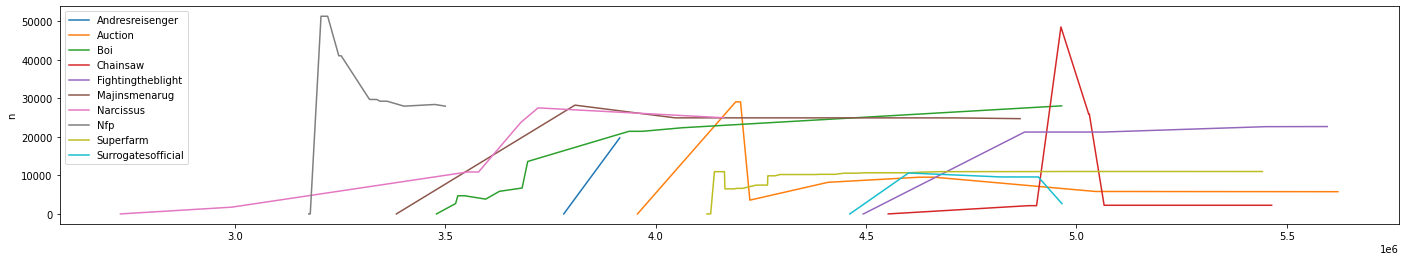

In [ ]:
top_collections = nft_transactions.groupby('Collection_cleaned').median_price.mean().sort_values()[-10:].index
nft_transactions[nft_transactions.Collection_cleaned.isin(top_collections)].groupby('Collection_cleaned').median_price.plot(legend=True, ylabel='n', figsize=(24,4))

In [ ]:
nft_transactions.loc[:,['median_price']].to_csv('data/')

,median_price
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
6071022,0.123044
6071023,0.123044
6071024,0.123044
6071025,0.123044
